In [7]:
# Release 1.0.0 Statistics

# First add these imports and setup
import sys
import os
sys.path.append("..")
from dotenv import load_dotenv
from utils.qdrant_client import COLLECTION_NAME, get_qdrant_client, test_connection

# Load environment variables
load_dotenv()

# Test connection to verify it's working
test_connection()

# Now print the collection name
print(COLLECTION_NAME)
import pandas as pd
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt

✅ Successfully connected to Qdrant Cloud.
Available collections: ['logistics_datapoints']
✅ Successfully connected to Google Embedding API.
Embedding dimension: 768
✅ Collection 'logistics_datapoints' exists with None points
logistics_datapoints


In [6]:
print (COLLECTION_NAME)

logistics_datapoints


In [8]:
# Display version info
display(Markdown("# Maritime Logistics Knowledge Base - v1.0.0"))
display(Markdown("*Release date: March 27, 2025*"))

# Maritime Logistics Knowledge Base - v1.0.0

*Release date: March 27, 2025*

In [12]:
# Define a robust dashboard stats function based on working patterns from other notebooks
def get_dashboard_stats(collection_name=COLLECTION_NAME):
    """Get collection statistics with robust error handling"""
    client = get_qdrant_client()
    
    try:
        # Get basic collection info
        collection_info = client.get_collection(collection_name)
        
        # Initialize counters
        datapoint_types = {}
        port_areas = {}
        entities = {}
        
        # Get all points using scroll method - this works in your other notebooks
        points, _ = client.scroll(
            collection_name=collection_name,
            limit=10000,
            with_payload=True,
            with_vectors=False
        )
        
        # Process each point to extract statistics
        for point in points:
            # Handle datapoint types safely
            dt = point.payload.get("datapoint_type")
            if dt:
                if isinstance(dt, list):
                    for item in dt:
                        datapoint_types[str(item)] = datapoint_types.get(str(item), 0) + 1
                else:
                    datapoint_types[str(dt)] = datapoint_types.get(str(dt), 0) + 1
            
            # Handle port areas safely
            pa = point.payload.get("port_area", point.payload.get("domain_area"))
            if pa:
                if isinstance(pa, list):
                    for item in pa:
                        port_areas[str(item)] = port_areas.get(str(item), 0) + 1
                else:
                    port_areas[str(pa)] = port_areas.get(str(pa), 0) + 1
                
            # Handle entities safely
            ent = point.payload.get("relevant_entity")
            if ent:
                if isinstance(ent, list):
                    for item in ent:
                        entities[str(item)] = entities.get(str(item), 0) + 1
                else:
                    entities[str(ent)] = entities.get(str(ent), 0) + 1
        
        # Create result with safer attribute access
        result = {
            "name": collection_name,
            "vectors_count": getattr(collection_info, 'vectors_count', None),
            "status": getattr(collection_info, 'status', 'unknown'),
            "total_points": len(points),
            "datapoint_types": datapoint_types,
            "port_areas": port_areas,
            "entities": entities
        }
        
        # Add any other available attributes that might be helpful
        if hasattr(collection_info, 'indexed_vectors_count'):
            result['indexed_vectors_count'] = collection_info.indexed_vectors_count
            
        return result
    
    except Exception as e:
        print(f"Error getting collection statistics: {e}")
        import traceback
        traceback.print_exc()
        return None

## Collection Statistics

**Total datapoints:** 1345

**Vector count:** None

**Status:** green

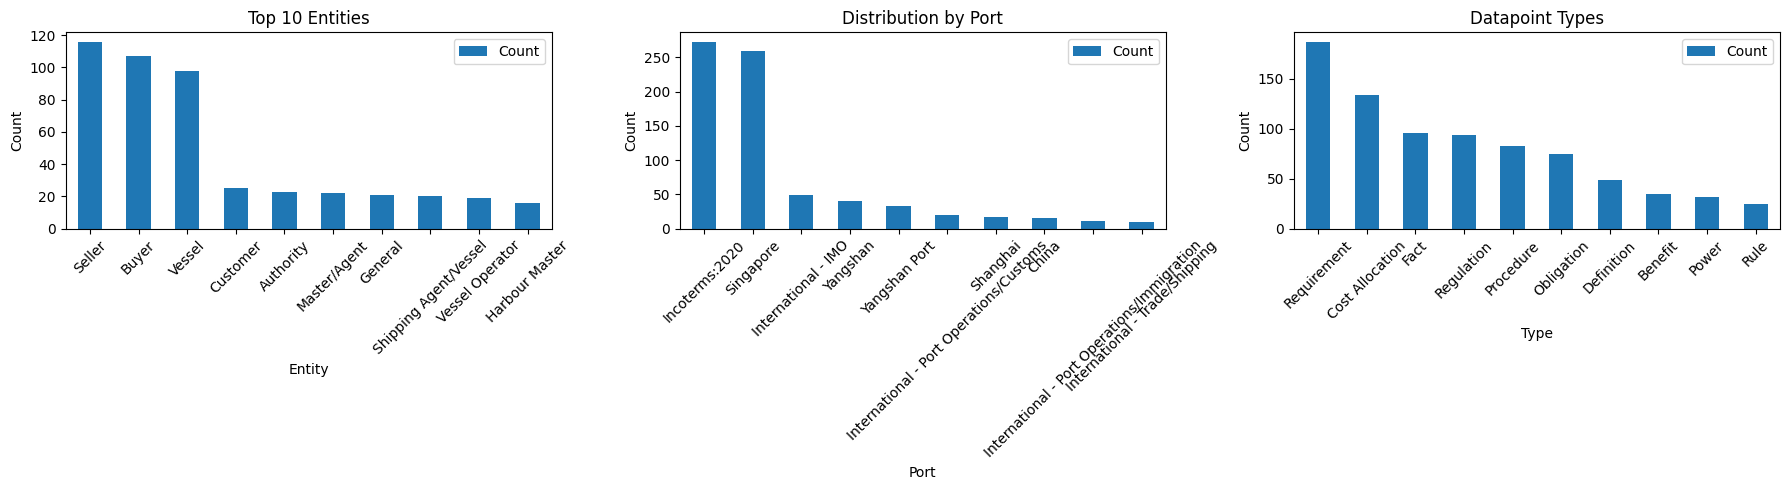

## Top 15 Normalized Entities

,Entity,Count
8,Seller,116
9,Buyer,107
4,Vessel,98
14,Customer,25
105,Authority,23
42,Master/Agent,22
35,General,21
57,Shipping Agent/Vessel,20
5,Vessel Operator,19
31,Harbour Master,16


In [13]:
# Use the specialized function
stats = get_dashboard_stats(COLLECTION_NAME)

# Display basic information about the collection
display(Markdown("## Collection Statistics"))

if stats is None:
    display(Markdown("**Error:** Could not retrieve collection statistics."))
else:
    # Basic statistics
    display(Markdown(f"**Total datapoints:** {stats['total_points']}"))
    display(Markdown(f"**Vector count:** {stats['vectors_count']}"))
    display(Markdown(f"**Status:** {stats['status']}"))
    
    # Entity analysis
    if 'entities' in stats and stats['entities']:
        try:
            # Entity distribution
            entity_df = pd.DataFrame(list(stats['entities'].items()), columns=['Entity', 'Count'])
            entity_df = entity_df.sort_values('Count', ascending=False)
            
            # Port area distribution
            port_df = pd.DataFrame(list(stats['port_areas'].items()), columns=['Port', 'Count'])
            port_df = port_df.sort_values('Count', ascending=False)
            
            # Datapoint types distribution
            type_df = pd.DataFrame(list(stats['datapoint_types'].items()), columns=['Type', 'Count'])
            type_df = type_df.sort_values('Count', ascending=False)
            
            # Display charts
            try:
                fig, axs = plt.subplots(1, 3, figsize=(18, 5))
                
                # Plot entity distribution (top 10)
                entity_df.head(10).plot.bar(x='Entity', y='Count', ax=axs[0], rot=45)
                axs[0].set_title('Top 10 Entities')
                axs[0].set_ylabel('Count')
                
                # Plot port distribution (top ports)
                port_df.head(min(len(port_df), 10)).plot.bar(x='Port', y='Count', ax=axs[1], rot=45)
                axs[1].set_title('Distribution by Port')
                axs[1].set_ylabel('Count')
                
                # Plot datapoint type distribution (top types)
                type_df.head(min(len(type_df), 10)).plot.bar(x='Type', y='Count', ax=axs[2], rot=45)
                axs[2].set_title('Datapoint Types')
                axs[2].set_ylabel('Count')
                
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error creating charts: {e}")
            
            # Display top entities as a table
            display(Markdown("## Top 15 Normalized Entities"))
            display(entity_df.head(15))
            
        except Exception as e:
            display(Markdown(f"**Error processing statistics:** {str(e)}"))
    else:
        display(Markdown("**No entity data available in the collection**"))